In [23]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm

# Building the PDF from particle releases

In [8]:
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

In [9]:
# for the 16 different depths, declare the indexes of the particles starting at that depth

level_indexes = {}
dz = 100
n_levels = 16

for i in range(n_levels):
    level_indexes[i*dz] = pset_1.trajectory[i::n_levels]

In [10]:
p1 = pset_1.isel(trajectory=level_indexes[0])
# p1.compute()

In [11]:
p1

<xarray.Dataset> Size: 48MB
Dimensions:     (trajectory: 4096, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 33kB 0 16 32 48 ... 65472 65488 65504 65520
Data variables:
    lat         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [12]:
64*64

4096

In [13]:
2**11 + 32

2080

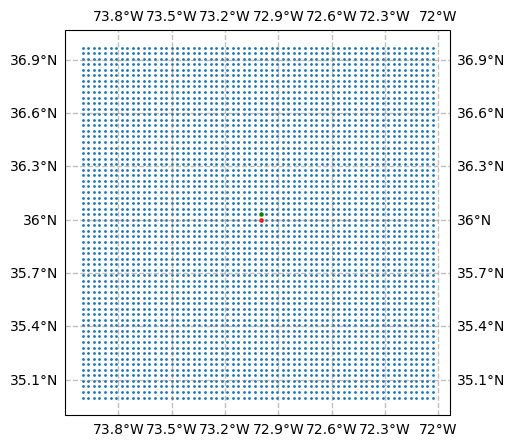

In [14]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

pp = 2**11 + 2**5 + 2**6

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='g')


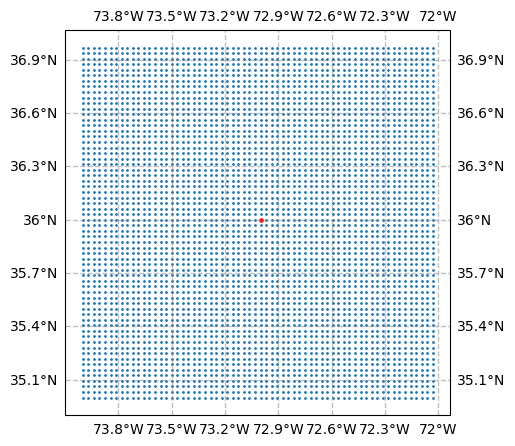

In [16]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

# pp = 2**11 + 2**5 + 2**6
# plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='g')

In [38]:
pp = 2**5 + 2**11
px1 = p1.isel(trajectory=pp)
px2 = p1.isel(trajectory=pp+1)

In [39]:
px1

<xarray.Dataset> Size: 13kB
Dimensions:     (obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
    trajectory  int64 8B 33280
Data variables:
    lat         (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    lon         (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    time        (obs) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    z           (obs) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [40]:
xr.concat([px1, px2], dim='trajectory')

<xarray.Dataset> Size: 25kB
Dimensions:     (trajectory: 2, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 16B 33280 33296
Data variables:
    lat         (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 6kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

# Building the PDF 

# 1. Cross-ensemble 1 particle distribution
We take the same particle at the surface for all 50 member ensemble and build two PDFs.
1. 𝑝(𝑿(𝑡 + 𝜏)−𝑿(𝑡) | 𝑿(𝑡), 𝑡, 𝜏),
where $\vec{X}(t)$ is the position of the particles at time $t$ and $\vec{X}(t + \tau)$ is the position of the particle after $\tau$.

2. Probability of following similar path.


In [41]:
member = 1
path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
pset_member = xr.open_zarr(path)
pset_member_aux = pset_member.isel(trajectory=level_indexes[0])

particle_index = 2**5 + 2**11
pset_member = pset_member.isel(trajectory=particle_index)

for member in tqdm(range(2,51)):
    path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
    pset_member_aux = xr.open_zarr(path)
    pset_member_aux = pset_member_aux.isel(trajectory=level_indexes[0])
    pset_member_aux = pset_member_aux.isel(trajectory=particle_index)
    
    pset_member = xr.concat([pset_member, pset_member_aux], dim='trajectory')
    
    

100%|██████████| 49/49 [00:10<00:00,  4.76it/s]


In [42]:
pset_member

<xarray.Dataset> Size: 584kB
Dimensions:     (trajectory: 50, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 400B 2080 33280 33280 ... 33280 33280 33280
Data variables:
    lat         (trajectory, obs) float64 146kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 146kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 146kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 146kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [44]:
pset_member.compute()

KeyboardInterrupt: 

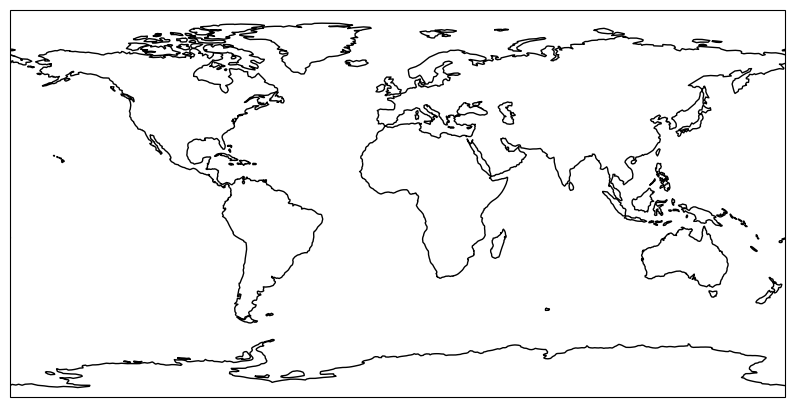

In [43]:
# plot the first 45 particles with land from cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-180, 180, -90, 90])

# for i in range(400):
ax.plot(pset_member.lon[:, :].T, pset_member.lat[:, :].T);
# ax.set_title('Member 001 Jan-Dec 2010 | Surface release')